In [2]:
! pip install --quiet  "urllib3" "seaborn"

In [1]:
import sys  
sys.path.insert(0, r"C:\\Users\jorge\\Documents\\Projects Jorge C\\DRUIDA PROJECT\\POC\\druida_V01\\src\\")

import os

from __future__ import print_function
#from Utilities.SaveAnimation import Video



from druida import Stack
from druida import setup

from druida.DataManager import datamanager
from druidaHFSS.modules import tools
from druida.tools import utils


#import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

from torchvision import transforms

import glob
from tqdm.notebook import tqdm
import random
import numpy as np
import pandas as pd

import argparse


plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")

# Setting the seed
#L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


<Figure size 640x480 with 0 Axes>

In [2]:
boxImagesPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images Jorge Cardenas 512\\"
DataPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Exports\\output\\"
simulationData="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\DBfiles\\"

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument("run_name",type=str)
parser.add_argument("epochs",type=int)
parser.add_argument("batch_size",type=int)
parser.add_argument("workers",type=int)
parser.add_argument("gpu_number",type=int)
parser.add_argument("device",type=str)
parser.add_argument("learning_rate",type=float)
parser.add_argument("condition_len",type=float) #This defines the length of our conditioning vector
parser.add_argument("metricType",type=float) #This defines the length of our conditioning vector
parser.add_argument("patch_size",type=int)

parser.run_name = "Predictor Training"
parser.epochs = 1
parser.batch_size = 10
parser.workers=0
parser.gpu_number=0
parser.image_size = 512
parser.dataset_path = os.path.normpath('/content/drive/MyDrive/Training_Data/Training_lite/')
parser.device = "cpu"
parser.learning_rate = 3e-4
parser.condition_len = 10
parser.metricType='AbsorbanceTM' #this is to be modified when training for different metrics.
parser.patch_size=32

categories=["box", "circle", "cross"]



In [4]:
dataloader = utils.get_data_with_labels(512, 512,0.95, boxImagesPath,parser.batch_size, drop_last=True)


## 1. Preprocessing

In [5]:
imagesPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\"

In [8]:

folders=glob.glob(imagesPath+"/*/", recursive = True)
files=[]

print(folders)
for folder in folders:
    
    if folder != imagesPath+"\\"+ "processed128\\":
        files=(files+glob.glob(folder+"/*"))



['C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\09a2f2c2-ad7f-11ee-bb2a-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\0ed3a0e8-a653-11ee-9db6-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\3be7fd33-bd16-11ee-be43-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\55628454-b316-11ee-82a4-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\56dee422-b317-11ee-bb58-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\7262ded2-a81d-11ee-8e0e-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\89962313-bbc8-11ee-a7fe-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\a03ae6f6-bc71-11ee-aef0-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\b34769e8-bcbb-11ee-bce8-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\b6b02fee-a8bb-11ee-8

In [9]:

for file in files:
    fileName_absolute = os.path.basename(file) 
    path=os.path.dirname(file)

    #ROI is 
    image_rgb=tools.cropImage( file,image_path=path,
                              image_name=fileName_absolute,
                              output_path=imagesPath, 
                             resize_dim=(128,128))
        


## Images Patches

In [5]:
images, targets, path, categories=next(iter(dataloader))


In [6]:
def patches(x, patch_size, flatten_channels):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
        
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
        """Batches, number of patches per image, each flattened patch size including  channel"""
    return x

### unflattened 

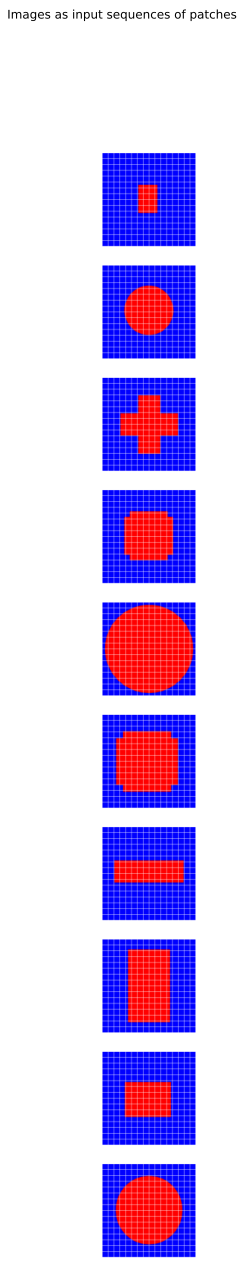

In [12]:
patch_size=parser.patch_size

#print(images.shape[0])
img_patches = patches(images, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(images.shape[0], 1, figsize=(30, 20))
fig.suptitle("Images as input sequences of patches")


for i in range(images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=16, normalize=True, pad_value=1)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

### Flattened

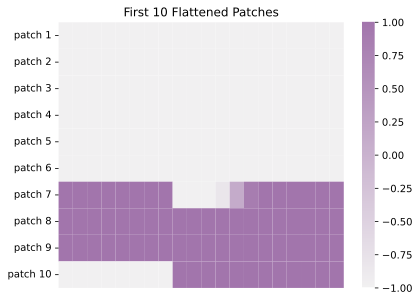

In [13]:
img_patches_flattened = patches(images, patch_size=patch_size, flatten_channels=True)
heat_map = img_patches_flattened.detach().numpy()[:,80:90:, 760:780:]

yticklabels = ['patch ' + str(i + 1) for i in range(10)]

plt.title('First 10 Flattened Patches')
ax = sns.heatmap(heat_map[0],  
                 cmap=sns.light_palette("#a275ac", as_cmap=True),
                 xticklabels=False, yticklabels=yticklabels,
                 linewidths=0.01, linecolor='white'
                )

## Architecture

In [12]:
"""Encoding"""

D= 3 * patch_size**2
N=512//patch_size

# weight matrix E
E = nn.Parameter(torch.randn(parser.batch_size,D, D))

patch_embeddings = torch.matmul(img_patches_flattened , E)
assert patch_embeddings.shape == (parser.batch_size, N**2 ,D)
print(patch_embeddings.shape)

torch.Size([3, 256, 3072])


In [13]:
"""class token"""
# init class token
class_token = nn.Parameter(torch.randn(parser.batch_size, 1, D))
print(class_token.shape)
patch_embeddings = torch.cat((class_token, patch_embeddings), 1)
print(patch_embeddings.shape)
assert patch_embeddings.shape == (parser.batch_size, N**2 +1, D)


torch.Size([3, 1, 3072])
torch.Size([3, 257, 3072])


In [7]:
model_kwargs={
        "embed_dim":  3 * parser.patch_size**2 ,
        "hidden_dim":  2*(3 * parser.patch_size**2),
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": parser.patch_size,
        "num_channels": 3,
        "num_patches": (parser.image_size//parser.patch_size)**2,
        "num_classes": 601,
        "dropout": 0.2,
    }



In [8]:
"""PRE LN architecture"""

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [9]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer usually 2-4x larger than embed_dim
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        #self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        self.cls_token = nn.Parameter(torch.randn(parser.batch_size, 1, num_channels * patch_size**2))
        
        
        self.pos_embedding = nn.Parameter(torch.randn(parser.batch_size, 1 + num_patches, embed_dim))

        
        
    def forward(self, x):
        # Preprocess input
        #x = img_to_patch(x, self.patch_size)
        B, T, _, _ = x.shape
        x = patches(x, patch_size=self.patch_size, flatten_channels=True)
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token #.repeat(B, 1, 1)
        #print("CLS Token  ",cls_token.shape)
        x = torch.cat([cls_token, x], dim=1)

        pos_embed=self.pos_embedding
        #print("Positional Embedd ",pos_embed.shape)
        
        x = x + pos_embed
        #print("x ", x.shape)
        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        
            # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [10]:
# unit test on vision transformer
channel_size = 3

# number of classes CIFAR-10
n_class = model_kwargs["num_classes"]

# dropout probability
dropout_prob = 0.1

# Vit-base model configurations
n_layer = 8; 
n_head = 16; 

embedding_dim = model_kwargs["embed_dim"]
hidden_dim=model_kwargs["hidden_dim"]
num_patches=parser.image_size//parser.patch_size
num_patches=num_patches**2


# init vision transformer model

        
        
vision_transformer = VisionTransformer(embedding_dim,
                                       hidden_dim,
                                       channel_size,
                                       n_head,
                                       n_layer,
                                       n_class,
                                       parser.patch_size,
                                       num_patches, dropout_prob )


### just in case a unit test is needed

In [11]:

# compute vision transformer output
vit_output = vision_transformer(images)

assert vit_output.size(dim=1) == n_class
print(vit_output.shape)

# get class probabilities
probabilities = F.softmax(vit_output[0], dim=0)
# probabilities should sum up to 1
print(torch.sum(probabilities))

torch.Size([10, 601])
tensor([0.0003, 0.0061, 0.0005, 0.0033, 0.0013, 0.0015, 0.0027, 0.0006, 0.0026,
        0.0013, 0.0013, 0.0009, 0.0028, 0.0013, 0.0016, 0.0021, 0.0024, 0.0016,
        0.0030, 0.0004, 0.0015, 0.0018, 0.0040, 0.0067, 0.0015, 0.0035, 0.0004,
        0.0010, 0.0020, 0.0013, 0.0012, 0.0007, 0.0010, 0.0014, 0.0022, 0.0062,
        0.0005, 0.0012, 0.0029, 0.0019, 0.0008, 0.0036, 0.0015, 0.0018, 0.0013,
        0.0012, 0.0008, 0.0028, 0.0020, 0.0010, 0.0006, 0.0016, 0.0011, 0.0011,
        0.0018, 0.0009, 0.0009, 0.0009, 0.0019, 0.0010, 0.0017, 0.0007, 0.0034,
        0.0012, 0.0012, 0.0037, 0.0013, 0.0004, 0.0030, 0.0007, 0.0007, 0.0032,
        0.0014, 0.0024, 0.0012, 0.0030, 0.0009, 0.0018, 0.0020, 0.0033, 0.0010,
        0.0011, 0.0026, 0.0012, 0.0011, 0.0008, 0.0018, 0.0006, 0.0017, 0.0019,
        0.0009, 0.0029, 0.0016, 0.0012, 0.0008, 0.0005, 0.0006, 0.0010, 0.0033,
        0.0014, 0.0025, 0.0010, 0.0015, 0.0009, 0.0009, 0.0014, 0.0016, 0.0012,
        0.0008, 0.

# Training


In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.optim as optimizer

from IPython.display import HTML

import glob
from tqdm.notebook import tqdm


In [13]:
def join_simulationData():
    df = pd.DataFrame()

    for file in glob.glob(simulationData+"*.csv"): 
        df2 = pd.read_csv(file)
        df = pd.concat([df, df2], ignore_index=True)
    
    df.to_csv('out.csv',index=False)
    
join_simulationData()   

In [14]:
import json

Substrates={"Rogers RT/duroid 5880 (tm)":0}
Materials={"copper":0,"pec":1}
Surfacetypes={"Reflective":0,"Transmissive":1}
TargetGeometries={"circ":0,"box":1, "cross":2}
           
def set_conditioning(target,path,categories):
    df = pd.read_csv("out.csv")
    arr=[]

    for idx,name in enumerate(path):
        series=name.split('_')[-1].split('.')[0]
        batch=name.split('_')[4]
        iteration=series.split('-')[-1]
        row=df[(df['sim_id']==batch) & (df['iteration']==int(iteration))  ]

        
        target_val=target[idx]
        category=categories[idx]
        geometry=TargetGeometries[category]
        
        """"
        surface type: reflective, transmissive
        layers: conductor and conductor material / Substrate information
        """
        surfacetype=row["type"].values[0]
        surfacetype=Surfacetypes[surfacetype]
        
        layers=row["layers"].values[0]
        layers= layers.replace("'", '"')
        layer=json.loads(layers)
        
        materialconductor=Materials[layer['conductor']['material']]
        materialsustrato=Substrates[layer['substrate']['material']]
        
        
        if (target_val==2): #is cross. Because an added variable to the desing 
            
            sustratoHeight= json.loads(row["paramValues"].values[0])
            sustratoHeight= sustratoHeight[-2]
        else:
        
            sustratoHeight= json.loads(row["paramValues"].values[0])
            sustratoHeight= sustratoHeight[-1]
        
        arr.append([geometry,surfacetype,materialconductor,materialsustrato,sustratoHeight,1,1,1,1,1])
    
    return arr


conditions=set_conditioning(targets, path, categories)
conditions

[[0, 0, 0, 0, 0.787, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 1.575, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 1.575, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 1.575, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 1.575, 1, 1, 1, 1, 1],
 [2, 0, 0, 0, 0.787, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 0.252, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 0.252, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0.508, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0.787, 1, 1, 1, 1, 1]]

In [15]:
#### #File reading conf
a = []
idx=0
iters=0


"""using weigth decay regularization"""
opt = optimizer.Adam(vision_transformer.parameters(), lr=parser.learning_rate, betas=(0.5, 0.999),weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
vision_transformer.train()

loss_values, valid_loss_list = [], []
acc=[]

In [ ]:
 
if parser.device!='cpu':
    vision_transformer.to('cuda')

# prepare model fr training
vision_transformer.train()


for epoch in range(parser.epochs):
    x=0
    running_loss = 0.0
    i=0
    print('Epoch {}/{}'.format(epoch, parser.epochs - 1))
    print('-' * 10)
    
    #dataloader = utils.get_data_with_labels(512, 512,0.9, boxImagesPath,parser.batch_size,drop_last=True)


    for data in tqdm(dataloader):
        
        if parser.device!='cpu':
            inputs, classes, names, classes_types = data.to('cuda')
        else:
            inputs, classes, names, classes_types = data

            
        a = []
        idx=0
        
        """lookup for data corresponding to every image in training batch"""
        for name in names:
            series=name.split('_')[-1].split('.')[0]
            batch=name.split('_')[4]
            for name in glob.glob(DataPath+batch+'\\files\\'+'/'+parser.metricType+'*'+series+'.csv'): 
                
                #loading the absorption data
                train = pd.read_csv(name)
                values=np.array(train.values.T)
                a.append(values[1])
                
                
        a=np.array(a)     
            
        conditioningArray=torch.FloatTensor(set_conditioning(classes, path, categories))

        if conditioningArray.shape[1]==parser.condition_len:
            
            
            opt.zero_grad()

            
            outmap_min, _ = torch.min(conditioningArray, dim=1, keepdim=True)
            outmap_max, _ = torch.max(conditioningArray, dim=1, keepdim=True)
            conditioningTensor = (conditioningArray - outmap_min) / (outmap_max - outmap_min)

            
                    # feedforward data
            y_predicted = vision_transformer(images)

            y_truth = torch.tensor(a)
        
             # clear grad

            
            #print(y_truth.shape)
            #print(y_predicted.shape)

            errD_real = criterion(y_predicted.float(), y_truth.float())

           # print(y_predicted.argmax(dim=-1))
           # print(y_truth.argmax(dim=-1))

            acc_val= (y_predicted.argmax(dim=-1) == y_truth.argmax(dim=-1)).float().mean()
            acc.append((y_predicted.argmax(dim=-1) == y_truth.argmax(dim=-1)).float().mean())
            
            errD_real.backward()
            loss=errD_real.item()
            opt.step()
            scale = torch.tensor([10.0])

            running_loss +=loss


            x += 1
            i = i+1


            if i % 10 == 5:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss / 10:.3f} running loss:  {running_loss / 10:.3f}')
                print(f'accuracy: {acc_val :.3f} ')
            iters += 1
        else:
        
            break
    loss_values.append(running_loss)
    
    
   

Epoch 0/0
----------


  0%|          | 0/495 [00:00<?, ?it/s]

[1,     6] loss: 4.990 running loss:  29.407
accuracy: 0.000 


In [20]:
PATH = './trainedModelTM_abs_ViT.pth' 

torch.save(vision_transformer.state_dict(), PATH)

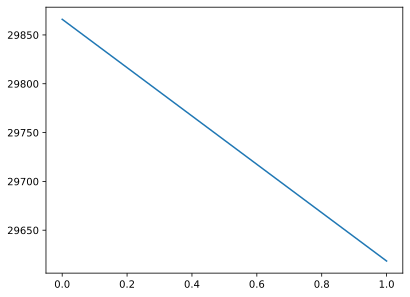

In [23]:
plt.plot(loss_values)
np.savetxt('loss_ABS_TM.out', loss_values, delimiter=',')

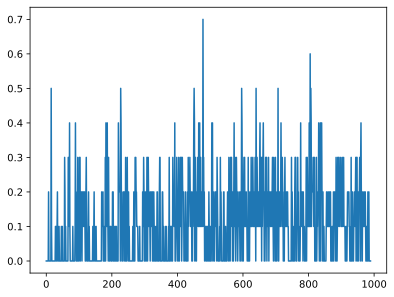

In [24]:
plt.plot(acc)
np.savetxt('acc_TM.out', acc, delimiter=',')

9418


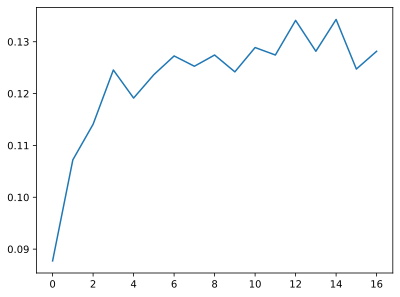

In [5]:
vectors = []
with open('acc_TM_128.out', 'r') as arch:
    for line in arch:
        vectors.append(eval(line.rstrip()))
        
acc=np.array(vectors).T
size= len(acc)
print(size)
chunkSize=554

division=size//chunkSize
acc_split=np.split(acc,division)

acc_mean=np.mean(acc_split, axis=1)

plt.plot(acc_mean)


## References
https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/11-vision-transformer.ipynb#scrollTo=d8000482
https://github.com/nerminnuraydogan/vision-transformer/blob/main/vision-transformer.ipynb